#  텍스트 기반 사기 탐지

In [17]:
import os
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import itertools

# 플랏 한글(맥)
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 자연어(영어) 전처리 모듈
import nltk
from nltk import tokenize  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 자연어 분포 확인용 모듈
from nltk import FreqDist, Text
from wordcloud import WordCloud

#
from transformers import pipeline



## 1. 데이터 불러오기

In [2]:
data = pd.read_csv(glob.glob(os.getcwd()+'/data07**')[0])

# 비어있는 행 삭제 & 단어 길이 컬럼 추가
data = (
    data
    .loc[lambda x : x['Text'].notnull()]
    .assign(TextLength=lambda x : x['Text'].apply(lambda y : len(y)))
)

## 2. 분포 확인

In [3]:
display(data.sample(10))
print(data['Class'].value_counts())

,Text,Class,TextLength
11897,sbwhoeopWednesday September 1 2010 11:47 AMHH:...,0,25492
9578,MR WILLIAM DRALLO ...,1,3252
9348,Mitchell/mara/jake agree best thing for mohlo ...,0,174
5331,<DIV id=3Dhotbar_promo></DIV></TD></TR></TBODY...,1,678
2962,Madam SecretaryThanks again. n1send the Prince...,0,229
7350,7pm start timeCasual buffet dinner at their ho...,0,93
10084,H <hrod17@clintonemail.com>Saturday August 15 ...,0,139
3536,Mr Beko Eze Secretary to the Niger Delta Devel...,1,2981
7883,ATTENTION PLS=2C Pls go through and reply me n...,1,2486
11040,"Dear Beloveth,I am Prince Fayad W. Bolkiah, th...",1,1571


0    6742
1    5186
Name: Class, dtype: int64


In [5]:
print("> 정상 메일")
display(data[data['Class']==0].sample(3))
print("> 사기 메일")
display(data[data['Class']==1].sample(3))

> 정상 메일


,Text,Class,TextLength
1778,Ok. Call after 3. Thx.,0,22
3958,H <hrod17@clintonemail.com>Thursday April 15 2...,0,289
1434,Remind me to discuss when we talk,0,33


> 사기 메일


,Text,Class,TextLength
799,FROM MRS.SUZANA NUHAN VAYELIBERIA-WEST AFRICA....,1,687
474,"A Letter From Mr DennisDear Partner,=20My name...",1,986
4788,"Awaiting your immediate, urgent contact!\t\t\t...",1,231


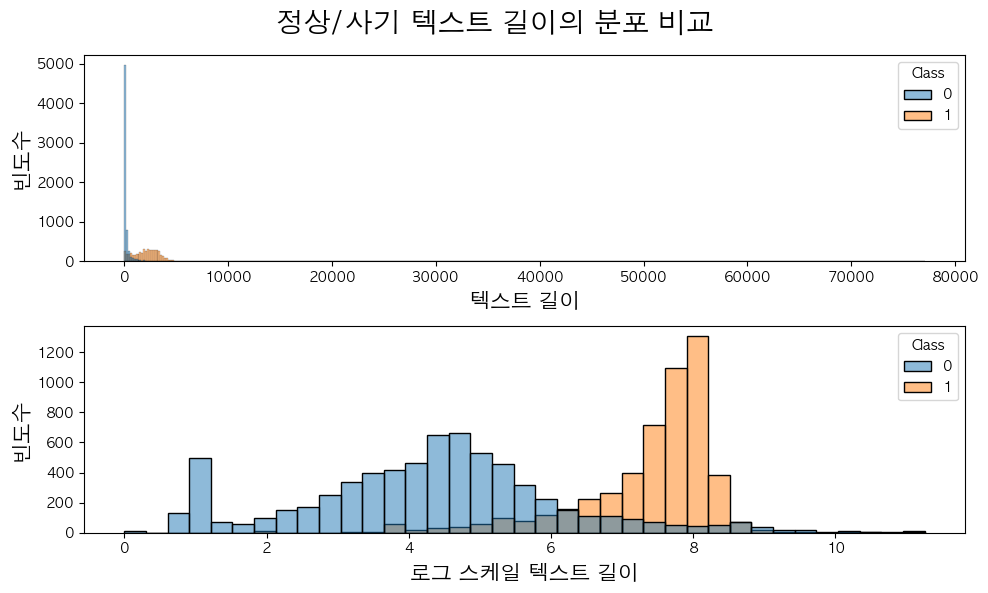

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.histplot(x=data['TextLength'], hue=data['Class'])
plt.xlabel("텍스트 길이", size=15)
plt.ylabel("빈도수", size=15)

plt.subplot(2,1,2)
sns.histplot(x=np.log(data['TextLength']), hue=data['Class'])
plt.xlabel("로그 스케일 텍스트 길이", size=15)
plt.ylabel("빈도수", size=15)
plt.suptitle("정상/사기 텍스트 길이의 분포 비교", size=20)
plt.tight_layout()
plt.show()

## 전처리 
ex. 예제 원본 문장 "Supply Quality China's EXCLUSIVE dimensions at Unb"
1. 표준화
    - 전체 소문자 처리
    - 처리예제. "supply quality china's exclusive dimensions at unb"
2. 토크나이징
    - 줄바꿈, 띄어쓰기 정도만 분리
    - 처리예제. ['Supply', 'Quality', 'China', "'s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', ',', 'We']
3. Punctuation 제거
    - 정규표현식으로 콤마 등 삭제
    - 처리예제. ['Supply', 'Quality', 'China', "s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', 'We']
4. 어간 추출(Stem)
    - 처리예제. ['suppli', 'qualiti', 'china',  "'s", 'exclus', 'dimens', 'unbeat', 'price.dear', 'sir', ',', 'pleas', 'inform']
5. Stopwords 제거

- 위 내용 코드로 한번에 처리하기
```python
   tokens_normal = []
    index_normal = (
        data
        .loc[lambda x : x['Class']==0]
        .index
    )
    for idx in tqdm(index_normal) : 
        token = [x for x in retokenize.tokenize(data['Text'].str.lower()[idx]) if x not in stopwords.words('english')]
        tokens_normal += token
```

- 참고. 캐싱
    - dill 패키지 이용

In [7]:
# LookupError 발생시 다음 실행
# nltk.download('all')
print("1. 표준화")
print('   ', data['Text'].str.lower()[0][:50])

print("2. 토크나이징")
print('   ', tokenize.word_tokenize(data['Text'][0])[:12])

print("3. Punctiation 제거")
retokenize = tokenize.RegexpTokenizer("[\w]+")
print('   ', retokenize.tokenize(data['Text'][0])[:12])

print("4. Stopwords 제거")
print('영어 stopwords 예 >', random.sample(stopwords.words('english'),7))
st = PorterStemmer()
print('   ', [st.stem(x) for x in tokenize.word_tokenize(data['Text'].str.lower()[0]) 
       if x not in stopwords.words('english')][:12])


1. 표준화
    supply quality china's exclusive dimensions at unb
2. 토크나이징
    ['Supply', 'Quality', 'China', "'s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', ',', 'We']
3. Punctiation 제거
    ['Supply', 'Quality', 'China', 's', 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price', 'Dear', 'Sir', 'We']
4. Stopwords 제거
영어 stopwords 예 > ['do', 'ain', 'her', 'in', 'through', 'didn', 'no']
    ['suppli', 'qualiti', 'china', "'s", 'exclus', 'dimens', 'unbeat', 'price.dear', 'sir', ',', 'pleas', 'inform']


In [8]:
sample_ratio = 1000/len(data)

ind = []
for i in range(2):
    ind_list = list(data[data['Class']==i].index)
    ind = ind + random.sample(ind_list, int(sample_ratio*len(ind_list)))
ind = np.sort(ind)
data = data.iloc[ind,:].reset_index(drop=True)

In [9]:
data['Class'].value_counts()

0    581
1    418
Name: Class, dtype: int64

### 3.1. 표준화

In [10]:
check_ind = random.sample(range(len(data)),3)

In [11]:
data['Text'] = data['Text'].str.lower()
display(data.iloc[check_ind,:])

,Text,Class,TextLength
861,there's a lot of good work in these papers and...,0,385
886,the word from ramallah is quite positive. if t...,0,1175
242,secure fax coming in 5 min.oa,0,29


### 3.2. 토크나이징

3.3에서 Punctuation 제거와 동시에 토크나이징을 해주기 때문에 다음 생략

In [12]:
# split_n = 10
# row_num = int(np.ceil(len(data)/split_n))

# result = []
# for i in range(split_n): # 한꺼번에 처리하는 것보다 10등분 나눠 처리하는 게 빠름
#     n1 = i*row_num
#     n2 = (i+1)*row_num
#     result = result + \
#         list(map(lambda x: tokenize.word_tokenize(x), data['Text'][n1:n2]))
# data['Text'] = result
# display(data.iloc[check_ind,:])

### 3.3 Punctuation 제거

In [13]:
split_n = 10
row_num = int(np.ceil(len(data)/split_n))
retokenize.toretokenize = tokenize.RegexpTokenizer("[\w]+")

result = []
for i in range(split_n): # 한꺼번에 처리하는 것보다 10등분 나눠 처리하는 게 빠름
    n1 = i*row_num
    n2 = (i+1)*row_num
    result = result + \
        list(map(lambda x: retokenize.tokenize(x), data['Text'][n1:n2]))
data['Text'] = result
display(data.iloc[check_ind,:])

,Text,Class,TextLength
861,"[there, s, a, lot, of, good, work, in, these, ...",0,385
886,"[the, word, from, ramallah, is, quite, positiv...",0,1175
242,"[secure, fax, coming, in, 5, min, oa]",0,29


### 3.4. Stopwords 제거

In [14]:
remove_words = set(stopwords.words('english'))
data['Text'] = data['Text'].apply(lambda x: list(set(x)-remove_words))
display(data.iloc[check_ind,:])

,Text,Class,TextLength
861,"[lot, btw, include, everyone, helped, sent, ov...",0,385
886,"[ofhaving, talk, responds, thorny, arab, refer...",0,1175
242,"[min, secure, 5, fax, oa, coming]",0,29


### * 전처리 후 단어 분포

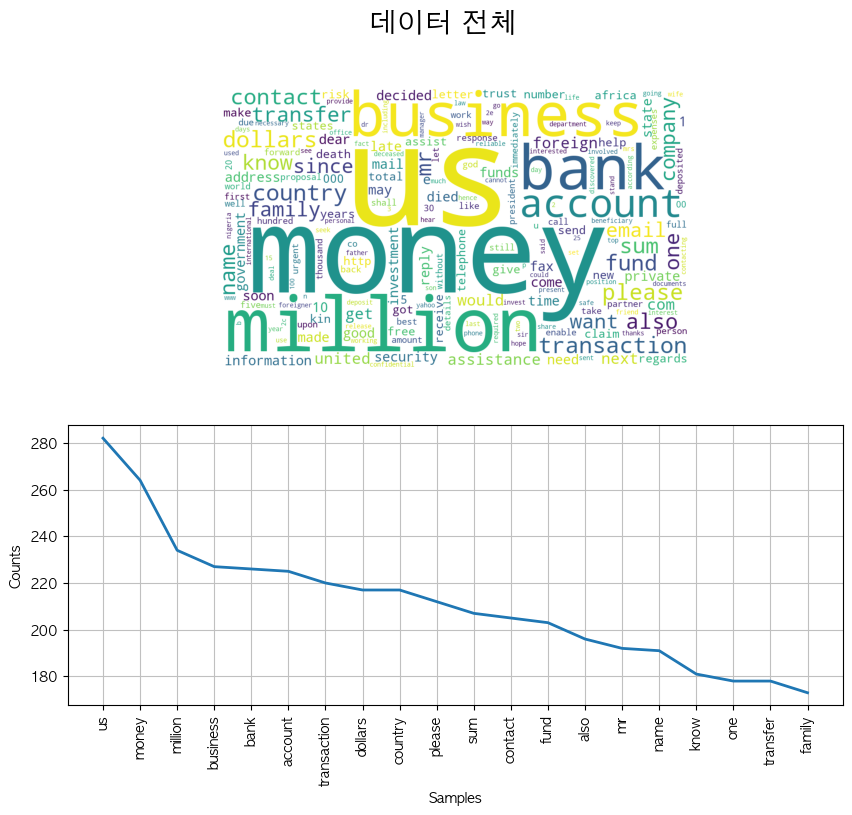

<Figure size 640x480 with 0 Axes>

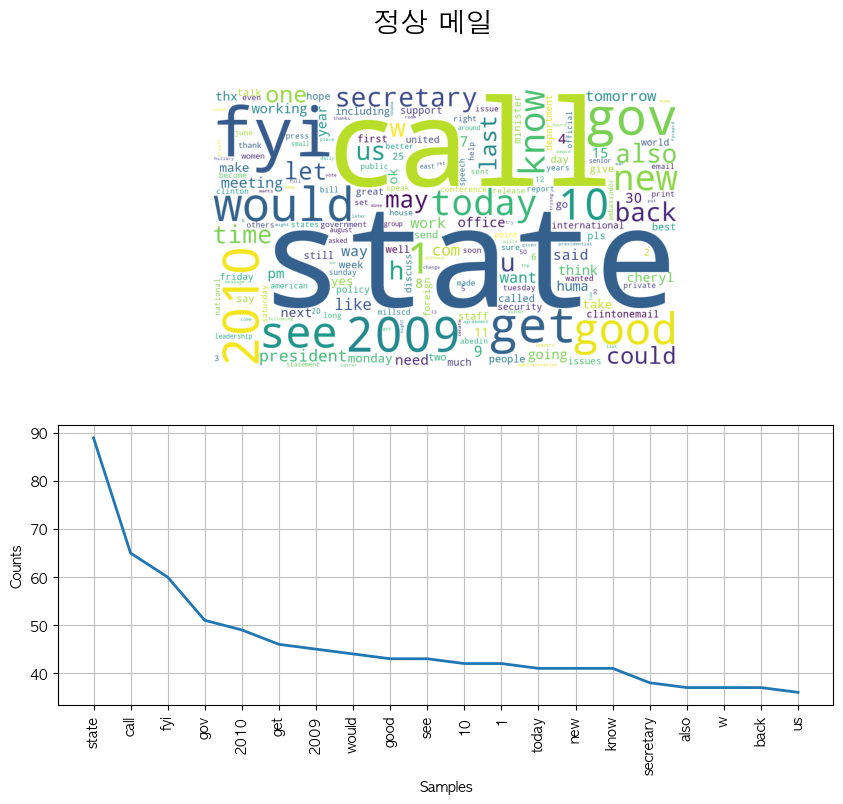

<Figure size 640x480 with 0 Axes>

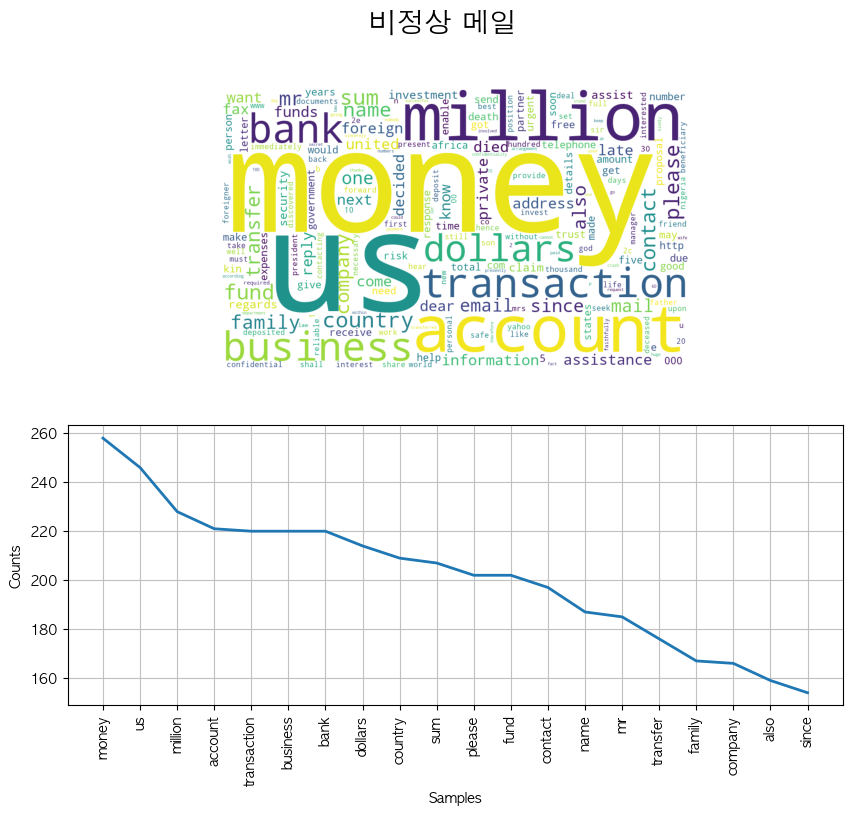

<Figure size 640x480 with 0 Axes>

In [48]:
for i in range(3):
    if i==0:
        tokens = data['Text'] 
        title = "데이터 전체"   
    elif i==1:
        tokens = data.loc[data['Class']==0,'Text']
        title = "정상 메일"  
    else:
        tokens = data.loc[data['Class']==1,'Text']
        title = "비정상 메일"  
        
    tokens = list(itertools.chain(*tokens))
    
    plt.figure(figsize=(10,8))
    plt.suptitle(title, size=20)
    plt.subplot(2,1,1)
    wc = WordCloud(width=1000, height=600, background_color='white', random_state=0)
    fd = FreqDist(tokens)
    plt.imshow(wc.generate_from_frequencies(fd))
    plt.axis('off')
    
    plt.subplot(2,1,2)
    text = Text(tokens)
    text.plot(20)
    plt.tight_layout()
    plt.show()

## 4. 이상탐지 모델링

In [52]:
# !pip install pytorch
# !pip install HuggingFace

from transformers import pipeline

classifier = pipeline('feature-extraction')

sample = classifier(data['Text'][0])
print(len(sample))
print(len(sample[0]))
print(len(sample[0][0]))

No model was supplied, defaulted to distilbert-base-cased and revision 935ac13 (https://huggingface.co/distilbert-base-cased).
Using a pipeline without specifying a model name and revision in production is not recommended.


RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.